# Baseline models

In the last colab, we built a linear regression model.  In this colab, we will build a couple of baseline models using `DummyRegression` and `permutation_test_score`.  We will compare performance of our linear regression model with these two baselines.


## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

We will use `ShuffleSplit` as a cross validation strategy.

In [ ]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

Let's load the data and split it into training and test.

In [ ]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=42)

# `LinearRegression` Model

* Build linear regression model with feature scaling as part of a pipeline.
* Train the model with 10-fold cross validation via `ShuffleSplit`.
* Capture errors on different folds.

In [ ]:
lin_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("lin_reg", LinearRegression())])

lin_reg_cv_results = cross_validate(lin_reg_pipeline, train_features,
                                    train_labels, cv=shuffle_split_cv,
                                    scoring="neg_mean_absolute_error",
                                    n_jobs=2)

lin_reg_errors = pd.Series(-lin_reg_cv_results["test_score"],
                           name="Linear regression error")

# `DummyRegressor`

In [ ]:
def dummy_regressor_baseline(strategy, constant_val=None, quantile_val=None):
  baseline_model_median = DummyRegressor(strategy=strategy,
                                         constant=constant_val,
                                         quantile=quantile_val)
  baseline_median_cv_results = cross_validate(baseline_model_median,
                                              train_features, train_labels,
                                              cv=shuffle_split_cv,
                                              scoring="neg_mean_absolute_error",
                                              n_jobs=2)
  return pd.Series(-baseline_median_cv_results["test_score"],
                   name="Dummy regressor error")

In [ ]:
baseline_median_cv_results_errors = dummy_regressor_baseline(strategy='median')
baseline_mean_cv_results_errors = dummy_regressor_baseline(strategy='mean')
baseline_constant_cv_results_errors = dummy_regressor_baseline(
    strategy='constant', constant_val=2)
baseline_quantile_cv_results_errors = dummy_regressor_baseline(
    strategy='quantile', quantile_val=0.55)

Let's compare performance of these dummy regressors:

In [ ]:
dummy_error_df = pd.concat([baseline_median_cv_results_errors,
                            baseline_mean_cv_results_errors,
                            baseline_constant_cv_results_errors,
                            baseline_quantile_cv_results_errors],
                         axis=1)
dummy_error_df.columns = ['Median CV', 'Mean CV', 'Constant CV', 'Quantile CV']

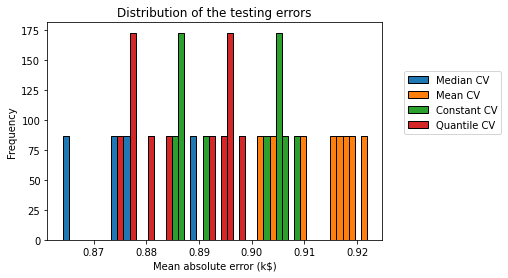

In [ ]:
dummy_error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Distribution of the testing errors")

# `permutation_test_score`

It permutes the target to generate randomized data and computes the empirical p-value against the null hypothesis, that features and targets are independent.

Here we are interested in `permutation_score` returned by this API, which indicates score of the model on different permutations.

In [ ]:
score, permutation_score, pvalue = permutation_test_score(
    lin_reg_pipeline, train_features, train_labels,
    cv=shuffle_split_cv, scoring="neg_mean_absolute_error",
    n_jobs=2, n_permutations=30)
permutation_errors = pd.Series(-permutation_score, name="Permuted error")

In [ ]:
print (permutation_score)

[-0.91446539 -0.91608713 -0.91501122 -0.91112203 -0.91326112 -0.91428719
 -0.91694297 -0.90660687 -0.90873595 -0.91546138 -0.9084695  -0.91174023
 -0.91857102 -0.91467076 -0.90396709 -0.91239289 -0.91095499 -0.91729623
 -0.90529415 -0.91436609 -0.91993036 -0.91661883 -0.91104746 -0.91563156
 -0.91014294 -0.91526135 -0.90680247 -0.90796435 -0.91032999 -0.91545574]


# Model comparison

In [ ]:
error_df = pd.concat([lin_reg_errors, baseline_median_cv_results_errors, permutation_errors],
                         axis=1)

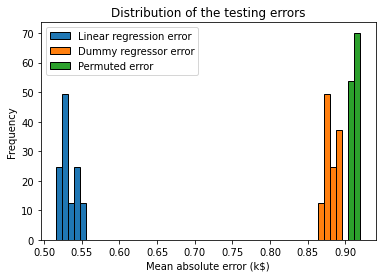

In [ ]:
error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(loc="best")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Distribution of the testing errors")

Our model has better performance than the two baselines.  However our model needs to improve it further.

# Summary

We implemented a couple of baselines - based on `DummyRegressor` and `permutation_test_score`.

In this colab, we used all strategies for `DummyRegressor`.  While using this in practice, we need to use only one of these strategies depending on the dataset.